### Import libraries
* numpy for simple data manipulation
* pandas and geopandas for data analysis
* matplotlib to plot data visually

In [409]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from fiona.crs import from_epsg
import os

from matplotlib import animation, rc
from IPython.display import HTML

### Data
Define arbitrary population distribution weights for building types for this example

In [245]:
weights = pd.DataFrame({
  'Commercial': [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
  'Administrative': [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
  'Residential': [1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1],
}, index=list(range(1, 24, 2))).T

weights.head()

,1,3,5,7,9,11,13,15,17,19,21,23
Commercial,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
Administrative,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
Residential,1.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0


Define daytime and nighttime hours

In [246]:
day = ['7', '11', '13', '15', '17', '19', '21']
night = ['23', '1', '3', '5']

#### Open input datasets:
* Buildings
* Administrative units
* Mobile phone users activity data associated with the administrative units
* Grid for data aggregation

First, open pilot area with Geopandas:

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe1a7fddb38>,)

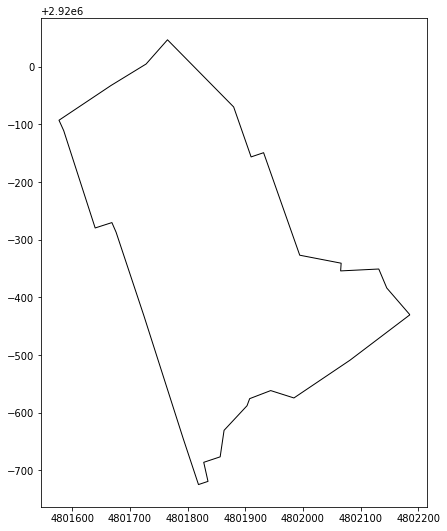

In [410]:
area = gpd.read_file('data/area.geojson').to_crs(epsg=3035)

def plotArea():
    return (area.plot(color="none", edgecolor="black", figsize=(7,9)),)

plotArea()

#### Next, open buildings spatial dataset including their attributes with Geopandas
Here are the first few building entries and their plot on top of the pilot area distinguished by usage type.

,B_ID,AREA_ID,aggregated_type,census_population,floors,geometry
0,505639702,10014,Residential,12.0,6.0,"(POLYGON ((4801964.04852097 2919507.381313595,..."
1,505892702,10014,Residential,34.5,6.0,(POLYGON ((4801808.535110435 2919817.198085646...
2,505729702,10014,Commercial,NaN,4.0,"(POLYGON ((4801793.09225574 2919808.870167085,..."
3,505907702,10014,Residential,24.5,7.0,(POLYGON ((4801811.718258977 2919735.405286827...
4,505693702,10014,Residential,7.5,4.0,(POLYGON ((4801774.751116849 2919850.972140913...


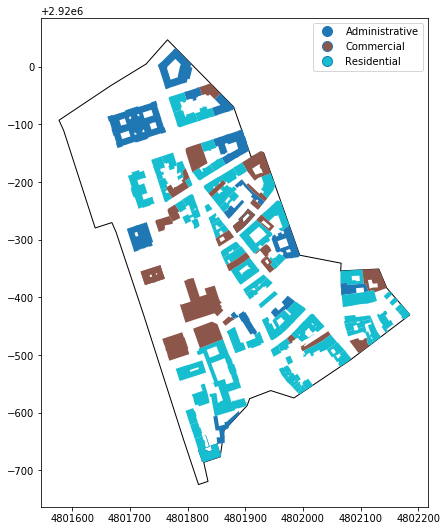

In [321]:
buildings = gpd.read_file('data/buildings.geojson').to_crs(epsg=3035)
buildings.plot(ax=plotArea()[0], column="aggregated_type", legend=True)
buildings.head()

#### Open mobile phones users activity data
The data are associated with small scale administrative units and available for every other hour. We use Pandas to open and analyze tabular data. Visit and transit columns show how many mobile phone users stayed in the specified area for a period of time longer and shorter than 30 minutes respectively. We mainly refer to the visit column as the transit data rarely apply to buildings.

In [322]:
mobileActivity = pd.read_csv('data/mobile_activity.csv', index_col=0).groupby(["hour"])
mobileActivity.head()

,hour,AREA_ID,visit,transit
0,1,10014,2679.4,866.000000
1,3,10014,2598.0,612.000000
2,5,10014,2707.4,1442.150000
3,7,10014,3855.8,4237.733333
4,9,10014,4657.4,3129.800000
5,11,10014,5130.8,3819.200000
6,13,10014,5156.0,4314.800000
7,15,10014,4945.0,5065.200000
8,17,10014,4508.4,4146.400000
9,19,10014,4037.4,1907.600000


#### Finally, grid geospatial dataset is loaded
Grid cells are 100 by 100 meters and derived from the european statistical 1 km grid.

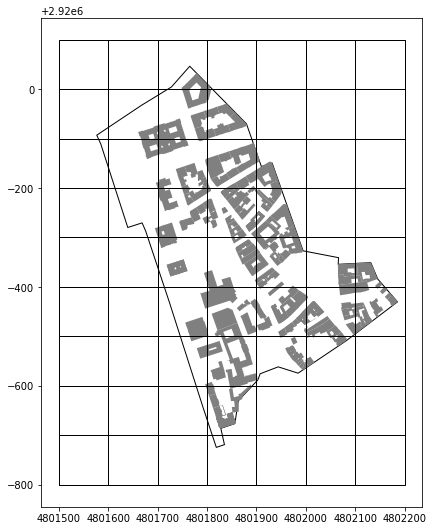

In [323]:
grid = gpd.read_file('data/grid.geojson').to_crs(epsg=3035)
grid.plot(ax=buildings.plot(ax=plotArea()[0], color="grey"), color="none", edgecolor="black")

Since there are multiple attribute entries for some buildings (multiple parts of the same building with separate entrances) and their respective footprint is unavailable, we first calculate the footprint of the building from its geometry and then divide it by the number of the parts of the building.

In [324]:
buildings['area'] = buildings['geometry'].area

buildingIDs = buildings['B_ID'].unique()

for ID in buildingIDs:
    l = len(buildings[buildings['B_ID'] == ID])
    buildings.loc[buildings['B_ID'] == ID, 'area'] /= l

We calculate the total floor area of the buildings / building parts.

The graph illustrates how the average number of floors for each building type influences its floor area.

aggregated_type
Administrative    2.504008
Commercial        5.489008
Residential       5.216830
Name: avg_floors, dtype: float64


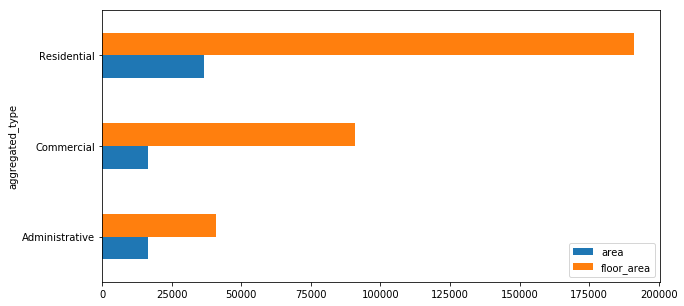

In [325]:
buildings["floor_area"] = buildings["area"] * buildings["floors"]
bAreas = buildings.groupby("aggregated_type").agg(sum)[["area", "floor_area"]]
bAreas.plot.barh(figsize=(10,5))
bAreas["avg_floors"] = bAreas.floor_area / bAreas.area
print(bAreas.avg_floors)

### Hourly population distribution
Mobile users visits are read from the mobile activity table for each hour

In [326]:
buildings["population_distribution_area"] = 0
mobileActivityVisits = float(mobileActivity.get_group((1))["visit"])
print(f"Mobile users visits for 1 AM: {mobileActivityVisits}")

Mobile users visits for 1 AM: 2679.4


**Population distribution area** is calculated using the weights and then summed.

In [327]:
def calculatePDA(row, hour):
    row["population_distribution_area"] = row["floor_area"] * (weights.loc[row["aggregated_type"], hour] / weights[hour].sum())
    return row

buildings = buildings.apply(calculatePDA, axis=1, hour=1)

totalDistributionArea = buildings["population_distribution_area"].sum()

print(f"Total distribution area: {totalDistributionArea} m^2")
buildings.head()

Total distribution area: 190986.83914170734 m^2


,B_ID,AREA_ID,aggregated_type,census_population,floors,geometry,area,floor_area,population_distribution_area
0,505639702,10014,Residential,12.0,6.0,"(POLYGON ((4801964.04852097 2919507.381313595,...",274.720231,1648.321389,1648.321389
1,505892702,10014,Residential,34.5,6.0,(POLYGON ((4801808.535110435 2919817.198085646...,504.501050,3027.006298,3027.006298
2,505729702,10014,Commercial,NaN,4.0,"(POLYGON ((4801793.09225574 2919808.870167085,...",157.026250,628.104999,0.000000
3,505907702,10014,Residential,24.5,7.0,(POLYGON ((4801811.718258977 2919735.405286827...,154.118722,1078.831051,1078.831051
4,505693702,10014,Residential,7.5,4.0,(POLYGON ((4801774.751116849 2919850.972140913...,451.832403,1807.329614,1807.329614


**Effective population** for the given hour is calculated using the *relative population distribution area*.

In [328]:
buildings["1"] = (buildings["population_distribution_area"] / totalDistributionArea) * mobileActivityPopulation

buildings.drop(["geometry"], axis=1).head()

,B_ID,AREA_ID,aggregated_type,census_population,floors,area,floor_area,population_distribution_area,1
0,505639702,10014,Residential,12.0,6.0,274.720231,1648.321389,1648.321389,23.124695
1,505892702,10014,Residential,34.5,6.0,504.501050,3027.006298,3027.006298,42.466595
2,505729702,10014,Commercial,NaN,4.0,157.026250,628.104999,0.000000,0.000000
3,505907702,10014,Residential,24.5,7.0,154.118722,1078.831051,1078.831051,15.135179
4,505693702,10014,Residential,7.5,4.0,451.832403,1807.329614,1807.329614,25.355459


**We now calculate the effective population for all remaining hours (3-23)**

In [329]:
for hour in range(3, 24, 2):
    buildings["population_distribution_area"] = 0
    mobileActivityVisits = float(mobileActivity.get_group((hour))["visit"])
    buildings = buildings.apply(calculatePDA, axis=1, hour=hour)
    totalDistributionArea = buildings["population_distribution_area"].sum()
    buildings[str(hour)] = (buildings["population_distribution_area"] / totalDistributionArea) * mobileActivityVisits

buildings.head()

,B_ID,AREA_ID,aggregated_type,census_population,floors,geometry,area,floor_area,population_distribution_area,1,3,5,7,9,11,13,15,17,19,21,23
0,505639702,10014,Residential,12.0,6.0,"(POLYGON ((4801964.04852097 2919507.381313595,...",274.720231,1648.321389,1648.321389,23.124695,22.422168,23.366350,17.040621,16.872123,18.587085,18.678375,17.913996,16.332348,17.843198,14.785803,23.521700
1,505892702,10014,Residential,34.5,6.0,(POLYGON ((4801808.535110435 2919817.198085646...,504.501050,3027.006298,3027.006298,42.466595,41.176462,42.910375,31.293695,30.984262,34.133648,34.301296,32.897577,29.993011,32.767561,27.152909,43.195662
2,505729702,10014,Commercial,NaN,4.0,"(POLYGON ((4801793.09225574 2919808.870167085,...",157.026250,628.104999,0.000000,0.000000,0.000000,0.000000,12.986908,12.858493,14.165491,14.235065,13.652520,12.447123,13.598564,11.268478,0.000000
3,505907702,10014,Residential,24.5,7.0,(POLYGON ((4801811.718258977 2919735.405286827...,154.118722,1078.831051,1078.831051,15.135179,14.675373,15.293343,11.153135,11.042852,12.165300,12.225050,11.724762,10.689568,11.678424,9.677351,15.395020
4,505693702,10014,Residential,7.5,4.0,(POLYGON ((4801774.751116849 2919850.972140913...,451.832403,1807.329614,1807.329614,25.355459,24.585162,25.620426,18.684474,18.499722,20.380120,20.480218,19.642102,17.907877,19.564473,16.212142,25.790762


### Effective population aggregation

Buildings type hierarchy is provided for visualization purposes for cases of conflicting building types of individual entries.

Building entries are then **aggregated by building identifier.**

In [330]:
buildingTypeHierarchy = ['Residential', 'Administrative', 'Commercial']

def mergeBuildingTypes(types):
    for t in buildingTypeHierarchy:
        if t in list(types):
            return t

buildings = buildings.groupby("B_ID").agg({**{
    "AREA_ID": lambda x: list(x)[0],
    "geometry": lambda x: list(x)[0],
    "floors": np.mean,
    "area": np.sum,
    "census_population": np.sum,
    "aggregated_type": mergeBuildingTypes
}, **{str(h): np.sum for h in range(1,24,2)}
})

buildings = gpd.GeoDataFrame(buildings, geometry='geometry')

buildings.head()

,AREA_ID,geometry,floors,area,census_population,aggregated_type,1,3,5,7,9,11,13,15,17,19,21,23
B_ID,,,,,,,,,,,,,,,,,,
505391702,10014,(POLYGON ((4802070.587818745 2919567.081544575...,7.0,438.638254,34.5,Residential,43.076326,41.767670,43.526478,31.743007,31.429131,34.623736,34.793791,33.369918,30.423647,33.238035,27.542768,43.815861
505392702,10014,(POLYGON ((4801947.208913239 2919660.740757134...,7.0,143.084272,4.0,Residential,14.051544,13.624659,14.198384,10.354603,10.252217,11.294300,11.349772,10.885303,9.924227,10.842283,8.984481,14.292781
505393702,10014,(POLYGON ((4801775.125980692 2919920.395964803...,6.0,792.155108,24.5,Residential,66.680000,64.654266,67.376812,49.136588,48.650724,53.595812,53.859049,51.654965,47.094286,51.450817,42.634828,67.824763
505394702,10014,"(POLYGON ((4801813.716978322 2919919.12501985,...",7.0,524.214481,12.0,Residential,51.480311,49.916343,52.018286,37.935916,37.560805,41.378661,41.581893,39.880229,36.359156,39.722617,32.916230,52.364127
505398702,10014,(POLYGON ((4802113.032213027 2919540.791865735...,7.0,166.959496,12.0,Residential,16.396203,15.898087,16.567545,12.082385,11.962914,13.178881,13.243610,12.701639,11.580196,12.651440,10.483642,16.677693


Day and night effective population sums and their relative differences to census population are calculated.

In [331]:
buildings["day"] = buildings[day].mean(axis=1)
buildings.loc[buildings["aggregated_type"] == "Residential", "day_diff"] = buildings["day"] * 100 / buildings["census_population"] - 100
buildings["night"] = buildings[night].mean(axis=1)
buildings.loc[buildings["aggregated_type"] == "Residential", "night_diff"] = buildings["night"] * 100 / buildings["census_population"] - 100
buildings = buildings.replace([np.inf, -np.inf], np.nan)

### Building level results

We can now display the hourly results in an animation:

In [436]:
fig, ax = plt.subplots(1, figsize=(7,9))
ax.set_aspect("equal")
area.plot(ax=ax, color='white', edgecolor='black')

def animate(i):
    h = (i + 1) * 2 - 1
    ax.set_title(f"Hour: {h}", fontsize=20)
#     b.plot(ax=ax, column=str(h), legend=True, scheme='fisher_jenks')
    b.plot(ax=ax, column=str(h), legend=True, vmax=750)
    if len(fig.axes) == 3: fig.axes[1].remove()
    fig.axes[1].set_position([0.8, 0.25, 0.8, 0.5])
    ax.set_position([0.125, 0.225, 0.620, 0.550])

anim = animation.FuncAnimation(fig, animate,
                               frames=12, interval=2000)
plt.close(fig)

In [437]:
HTML(anim.to_html5_video())

<Figure size 432x288 with 0 Axes>

### Grid interpolation

First we create a union of the grid and buildings to get building fragments for every grid cell.

Then we calculate the fragment area relative to the building footprint.

In [438]:
gbUnion = gpd.overlay(grid, buildings, how="union")

gbUnion["relative_fragment_area"] = gbUnion["geometry"].area / gbUnion["area"]

Effective population columns are multiplied by the **relative fragment area**.

In [439]:
popCols = [str(i) for i in range(1, 24, 2)] + ["census_population", "day", "night"]
cols = [str(i) for i in range(1, 24, 2)] + ["area", "census_population", "day", "night", "relative_fragment_area"]

gbUnion[popCols] = gbUnion[popCols].multiply(gbUnion["relative_fragment_area"], axis="index")

,1,3,5,7,9,11,13,15,17,19,21,23,census_population,day,night
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Building fragments are aggregated by grid identifier, which gives us effective population for the grid cells.

In [440]:
colAgg = {**{k: np.sum for k in cols}, **{"day_diff": np.mean, "night_diff": np.mean}}

fragmentAttributes = gbUnion.groupby("OBJECTID").agg(colAgg)
popGrid = grid.merge(fragmentAttributes, left_on="OBJECTID", right_index=True)
popGrid.head()

,OBJECTID,Join_Count,TARGET_FID,GRD_INSPIR,Shape_Leng,Shape_Area,geometry,1,3,5,7,9,11,13,15,17,19,21,23,area,census_population,day,night,relative_fragment_area,day_diff,night_diff
0,14856,1,14855,1kmN2919E4801,400.0,10000.0,(POLYGON ((4801500.000064867 2919299.999265373...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1,15101,1,15100,1kmN2919E4802,400.0,10000.0,(POLYGON ((4802000.000064934 2919399.999265403...,52.878071,51.271638,53.430652,38.965926,38.580631,42.502147,42.710897,40.963030,37.346355,40.801139,33.809949,53.785883,2867.673541,12.115467,39.585635,52.841561,2.230632,462.256116,650.537179
2,15578,1,15577,1kmN2919E4801,400.0,10000.0,(POLYGON ((4801700.000064886 2919599.999265525...,0.000000,0.000000,0.000000,139.740691,149.897764,165.134076,165.945135,159.154129,145.102220,146.322181,121.250183,0.000000,5510.464769,0.042461,148.949802,0.000000,1.404761,NaN,NaN
3,15576,1,15575,1kmN2919E4801,400.0,10000.0,"(POLYGON ((4801500.000064857 2919599.99926554,...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
4,15102,1,15101,1kmN2919E4802,400.0,10000.0,(POLYGON ((4802100.000064948 2919399.999265401...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


### Grid interpolation with transit data

In this case, we also calculate relative areas of non-building fragments and spread transit population among them evenly, since mobile phone users transit can be mostly attributed to streets (non-building areas). This is done only for illustrative purposes. Transit data could be distributed e.g. among a street network weighted by traffic flow data.

In [470]:
gbzUnion = gpd.overlay(grid, buildings, how="union")
gbzUnion = gpd.overlay(gbzUnion, area, how="union")

unionZoneAreas = gbzUnion[pd.notnull(gbzUnion["AREA_ID_2"])]

unionZoneAreas = unionZoneAreas.loc[unionZoneAreas.aggregated_type.isna()]

Fragment area is calculated for non-building fragments in each administrative unit.

In [471]:
unionZoneAreas["area"] = unionZoneAreas.geometry.area

**Transit data** are read.

In [472]:
transitData = pd.read_csv('data/mobile_activity.csv', index_col=0).drop(["visit"], axis=1).set_index(["AREA_ID", "hour"]).unstack("hour")
transitData.columns = transitData.columns.droplevel(0)
transitData

hour,1,3,5,7,9,11,13,15,17,19,21,23
AREA_ID,,,,,,,,,,,,
10014,866.0,612.0,1442.15,4237.733333,3129.8,3819.2,4314.8,5065.2,4146.4,1907.6,861.4,1044.5


In [473]:
unionZoneAreas = unionZoneAreas[["AREA_ID_2", "area"]].groupby("AREA_ID_2").agg(sum)

In [474]:
unionZoneAreas

,area
AREA_ID_2,
10014.0,129990.343158


We fill in the transit data and administrative unit area for its non-building fragments.

In [489]:
def aggregateUnion(row):
    if pd.isna(row.aggregated_type) and pd.notna(row.AREA_ID_2):
        row["area"] = float(unionZoneAreas.loc[row.AREA_ID_2])
        for i in transitData.columns:
            row[str(i)] = row[i]
    return row

gbzUnion = gbzUnion.apply(aggregateUnion, axis=1)
gbzUnion.loc[pd.notnull(gbzUnion["AREA_ID_2"])].head()

,OBJECTID,Join_Count,TARGET_FID,GRD_INSPIR,Shape_Leng,Shape_Area,AREA_ID,floors,area,census_population,aggregated_type,1,3,5,7,9,11,13,15,17,19,21,23,day,day_diff,night,night_diff,AREA_ID_2,geometry
7,15580,1,15579,1kmN2919E4801,400.0,10000.0,NaN,NaN,129990.343158,NaN,None,1.000000,1kmN2919E4801,10000.000000,NaN,NaN,1.000000,10000.000000,NaN,10000.000000,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,10014.0,"POLYGON ((4801927.264581956 2919664.361267402,..."
8,15580,1,15579,1kmN2919E4801,400.0,10000.0,10014.0,6.0,287.330983,0.0,Commercial,0.000000,0,0.000000,35.645706,35.293241,38.880611,39.071574,37.472640,34.164136,37.324543,30.929061,0.000000,36.212610,NaN,0.000000,NaN,10014.0,"POLYGON ((4801928.003466074 2919663.366661486,..."
9,15580,1,15579,1kmN2919E4801,400.0,10000.0,NaN,NaN,129990.343158,NaN,None,1.000000,1kmN2919E4801,10000.000000,NaN,NaN,1.000000,10000.000000,NaN,10000.000000,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,10014.0,"POLYGON ((4801934.800970146 2919663.007331204,..."
10,15579,1,15578,1kmN2919E4801,400.0,10000.0,NaN,NaN,129990.343158,NaN,None,1.000000,1kmN2919E4801,10000.000000,NaN,NaN,1.000000,10000.000000,NaN,10000.000000,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,10014.0,"POLYGON ((4801869.016171402 2919663.916396782,..."
11,15579,1,15578,1kmN2919E4801,400.0,10000.0,10014.0,5.0,525.385709,2.0,Residential,36.853808,35.7342,37.238934,27.157624,26.889089,29.622223,29.767713,28.549523,26.028851,28.436691,23.564124,37.486515,27.589535,1279.476767,36.828362,1741.418121,10014.0,"POLYGON ((4801871.824002887 2919665.498634078,..."


Relative fragment area is then calculated and effective population for the fragment determined.



In [ ]:
gbzUnion = gbzUnion.drop(transitData.columns, axis=1)

gbzUnion["relative_fragment_area"] = gbzUnion["geometry"].area / gbzUnion["area"]
gbzUnion[[str(i) for i in range(start_h, end_h+1, 2)] + ["census_population"]] = gbzUnion[[str(i) for i in range(start_h, end_h+1, 2)] + ["census_population"]].multiply(gbzUnion["relative_fragment_area"], axis="index")

gbzUnion[cols] = gbzUnion[cols].astype(float)
gbzUnion["aggregated_type"] = gbzUnion["aggregated_type"].astype(str)

fragmentAttributes = gbzUnion.groupby("OBJECTID").agg(sum)[cols]

popTransitGrid = grid.merge(fragmentAttributes, left_on="OBJECTID", right_index=True)